In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)

## Реализация и сравнение методов разделяющей гиперплоскости

Попробуем минимизировать лосс на примере обычной линейной регрессии:  
$$
L(w) = \|y - Xw \|_2^2 \rightarrow \min_w
$$
где $y$ размера $1\times1$, $x$ - вектор признаков размера $1 \times n$, а $w$ - матрица весов размера $n \times 1$
$$
\nabla_w L = X^{T}(Xw - y)
$$

Подготовим данные:

In [10]:
N = 100

X = np.random.randn(1, N)
target_weights = np.random.randn(N, 1)
y = X @ target_weights + np.random.normal(scale=0.1, size=1)

In [11]:
def mse(w):
  return np.mean((y - X @ w) ** 2)

In [12]:
def mse_grad(w):
  return X.T @ (X @ w - y)

Теперь напишем реализацию рассматриваемых методов

In [13]:
class GradientDescent:
  def __init__(self, lr, iterations):
    self.lr = lr
    self.iterations = iterations
    self.history = []
    self.time_history = []

  def solve(self, f, grad, initial_w):
    self.history = [f(initial_w)]
    self.time_history = [time.time()]
    w = initial_w.copy()

    for _ in range(self.iterations):
      w = w - self.lr * grad(w)
      self.time_history.append(time.time())
      self.history.append(f(w))
    return w


In [14]:
#initial_w = np.random.randn(N) + np.random.normal(scale=0.1, size=N)
initial_w = np.zeros(N)

gradient_descent = GradientDescent(lr=0.001, iterations=40)
gd_result = gradient_descent.solve(mse, mse_grad, initial_w)

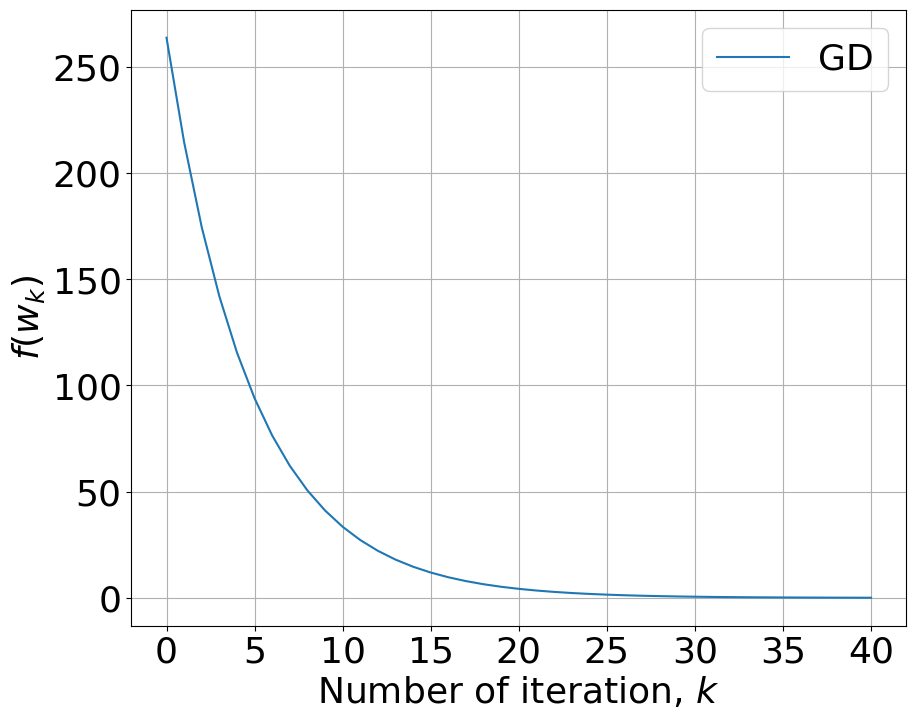

In [15]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)

plt.plot(gradient_descent.history, label="GD")

plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(w_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.grid(True)

Напомним алгоритм метода центров тяжести.

На входе некоторое замкнутое и ограниченное выпуклое непустое множество $G \equiv G_0$, содержащее искомое оптимальное множество $X^{*}$   
$t = 0$  
$\textbf{repeat}  $  
    Выбираем точку $x_{t+1}$ в $G_t$ как центр тяжести  
    Определяем новую разделяющую гиперплоскость и новое локализирующее множество $G_{t+1} = \{x \in G_t | (x - x_{t+1})^{T}f'(x_{t+1}) \leq 0\}$  
    $t = t + 1$    
$\textbf{untill}$  {$f'(x_{t+1}) \neq 0$ или $G_{t+1} \neq \emptyset$}

Сначала построим множество и его выпуклую оболочку  
Для того, чтобы найти центр тяжести, нужно построить выпуклую оболочку множества точек и через нее уже получить центроид  
Но, к сожалению, это очнь тяжелая операция (как раз минус данного метода), поэтому можно упростить вычисление до взятие среднего по точкам

In [16]:
from scipy.spatial import ConvexHull

points_G = np.random.randn(1000, N) # set of points
points_G = np.clip(points_G, -10, 10)
#convex_G = ConvexHull(points_G) # очень долго вычисляется, коллаб падает
convex_G = points_G

In [17]:
class CenterOfGravity:
  def __init__(self, iterations):
    self.iterations = iterations
    self.history = []

  def solve(self, f, initial_G):
    G = initial_G.copy()
    for _ in range(self.iterations):
      center_of_gravity = np.mean(G, axis=0) # center of gravity (approximate)
      self.history.append(f(center_of_gravity))

      gradient = mse_grad(center_of_gravity) # subgradient, in this case use gradient (mse is differentiated function)
      
      new_G = []
      for g in G:
        if (g - center_of_gravity).T @ gradient <= 0: # halfspace with cutting plane
          new_G.append(g)
      G = new_G

      if len(G) < 2:
        break

    return center_of_gravity

In [18]:
cg_method = CenterOfGravity(iterations=40)
cg_result = cg_method.solve(mse, convex_G)

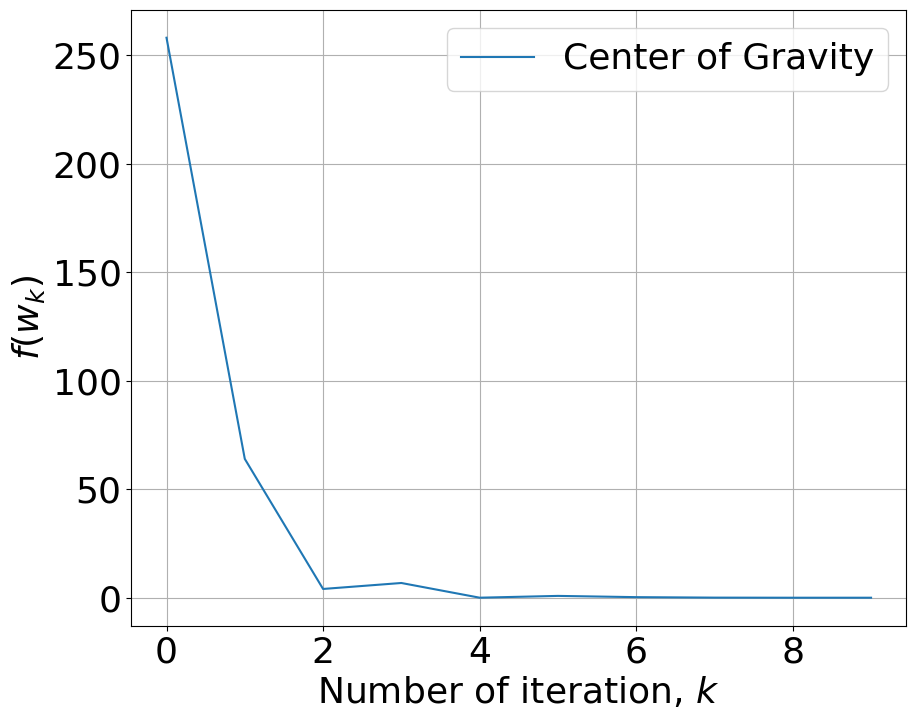

In [20]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)

plt.plot(cg_method.history, label="Center of Gravity")

plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(w_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.grid(True)

Теперь перейдем к алгоритму эллипсоидов  
Напомним, что здесь заменяется наше выпуклое множество на более простую геометрицескую фигуру - эллипсоид

In [21]:
import ellipsoid

points_E = np.random.randn(1000, N) # set of points
points_E = np.clip(points_E, -10, 10)

center, radii, rotation, B = ellipsoid.Ellipsoid().getMinVolEllipse(points_E, 0.01)

In [22]:
class EllipsoidMethod:
    def __init__(self, initial_center, iterations):
        self.center = initial_center
        self.iterations = iterations
        self.history = []


    def solve(self, f, points_E):
        ellips = points_E.copy()

        for _ in range(self.iterations):
            self.history.append(f(self.center))
            
            gradient = mse_grad(self.center)
            
            norm = np.linalg.norm(gradient)
            if norm < 0.001:
                break

            new_ellipsoid = []
            for e in ellips:
                if (e - self.center).T @ gradient <= 0: # halfspace with cutting plane
                    new_ellipsoid.append(e)
            ellips = new_ellipsoid
            
            if len(ellips) < 2:
                break
            
            self.center, radii, rotation, B = ellipsoid.Ellipsoid().getMinVolEllipse(np.array(ellips), 0.01)
            
        return self.center


In [23]:
ellips_method = EllipsoidMethod(center, iterations=40)
ellips_result = ellips_method.solve(mse, points_E)

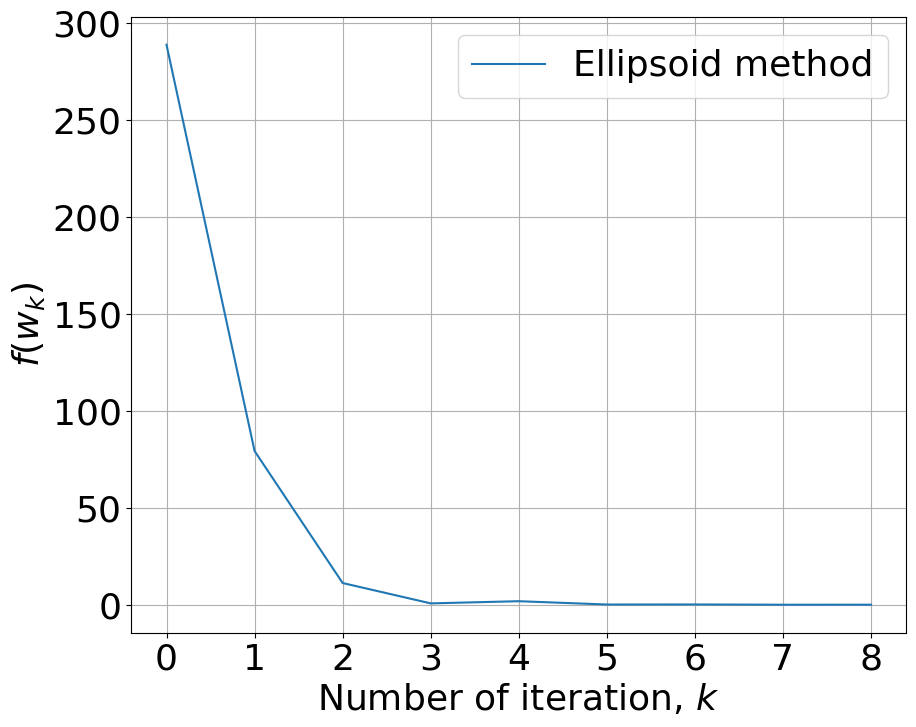

In [24]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)

plt.plot(ellips_method.history, label="Ellipsoid method")

plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(w_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.grid(True)

Сравним все три метода на одном графике

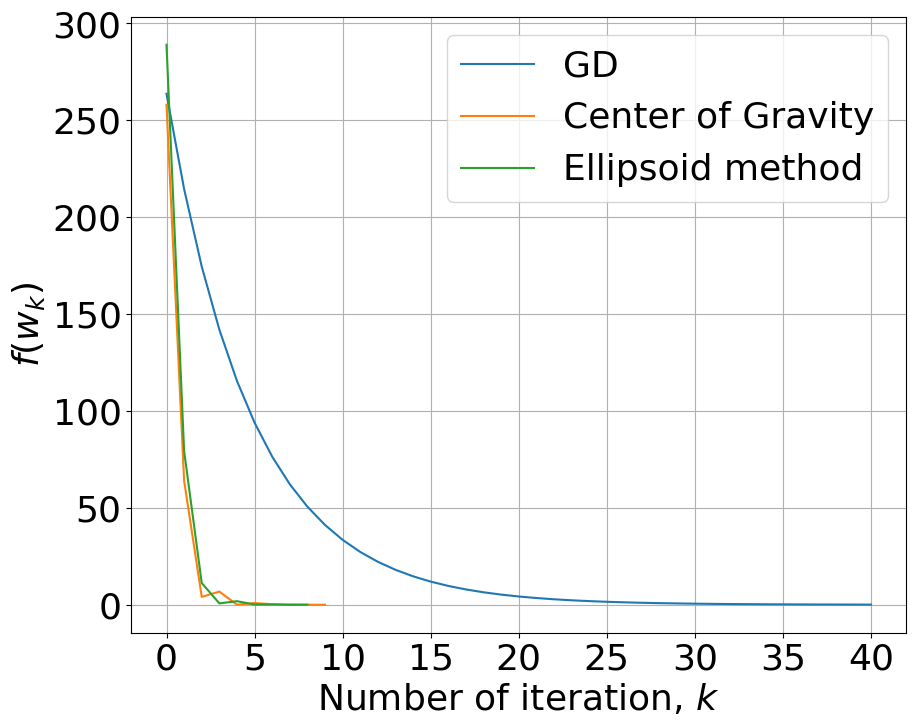

In [25]:
figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)

plt.plot(gradient_descent.history, label="GD")
plt.plot(cg_method.history, label="Center of Gravity")
plt.plot(ellips_method.history, label="Ellipsoid method")

plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(w_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.grid(True)

### Вывод:  
Методы разделяющей гиперплоскости действительно показывают себя лучше градиентного спуска, то есть сходятся быстрее  
По поводу различия метода центров тяжести и метода эллипсоидов: в данной работе в пространстве высокой размерности вычислить точный центр тяжести оказалось нереализуемо (из-за нехватки ОЗУ), поэтому могу заключить следующие различия этих методов:  
1) Метод эллипсоидов вычислительно быстрее, так как работаем с простыми геометрическими фигурами и его реально воспроизвести в пространствах большой размерности
2) Метод эллипсоидов сходится медленнее на практике, если вычислять центр тяжести честно, из-за того, что захватываются лишние точки при привидении множеств к эллипсоиду
